In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Apr 18 16:25:11 2017

@author: cyrano
"""
import time
import h5py
import numpy as np
import matplotlib.pyplot as plt

#from keras import regularizers
from keras.layers import Input, Dense, Activation
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.utils import np_utils

# 重构输出结果
def displayDigits(num,origin,decoded):
    plt.figure(figsize=(20, 4))
    
    for i in range(num):
        # display original
        ax = plt.subplot(2, num, i+1)
        plt.imshow(origin[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
        # display reconstruction
        ax = plt.subplot(2, num, i+1+num)
        plt.imshow(origin[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
    plt.show()

# plot the result
def plotResult(result):
    plt.figure
    plt.title("cost function")
    plt.plot(result.epoch,result.history['loss'],label="loss")
    plt.plot(result.epoch,result.history['val_loss'],label="val_loss")
    plt.scatter(result.epoch,result.history['loss'])
    plt.scatter(result.epoch,result.history['val_loss'])
    plt.legend(loc='upper right')
    plt.show()

    
##################################################

# 开始载入数据集
t0 = time.time()  # 打开深度学习计时器

from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# convert class vectors to binary class matrices (ie one-hot vectors)
nb_classes = 10
y_train = np_utils.to_categorical(y_train, nb_classes)
y_test  = np_utils.to_categorical(y_test, nb_classes)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

print("载入数据耗时: ",(time.time() - t0), "s")

Using TensorFlow backend.


(60000, 784)
(10000, 784)
(60000, 10)
(10000, 10)
载入数据耗时:  1.1634759902954102 s


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 196)               153860    
_________________________________________________________________
dense_2 (Dense)              (None, 784)               154448    
Total params: 308,308.0
Trainable params: 308,308
Non-trainable params: 0.0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 10s - loss: 0.3586 - acc: 0.7962 - val_loss: 0.2493 - val_acc: 0.7983
Epoch 2/50
60000/60000 [==============================] - 8s - loss: 0.2151 - acc: 0.8040 - val_loss: 0.1861 - val_acc: 0.8063
Epoch 3/50
60000/60000 [==============================] - 8s - loss: 0.1748 - acc: 0.8087 - val_loss: 0.1610 - val_acc: 0.8093
Epoch 4/50
60000/60000 [==============================] - 8s - loss: 0.1554 - acc: 0.8110 - val_

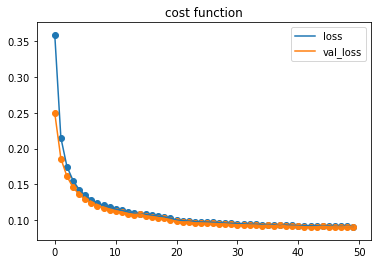

weight-encode:  (784, 196) bias-encode:  (196,)
weight-decode:  (196, 784) bias-decode:  (784,)
h1:  (60000, 196)


In [2]:
# 构建第一层 784 -> 196

encoding_dim = 196
input_img = Input(shape=(784,))

model1 = Sequential()
model1.add(Dense(encoding_dim,input_shape=x_train.shape[1:],activation='relu'))
model1.add(Dense(784,activation='relu'))

#encoder1 = Model(inputs=input_img, outputs=encoded1)
#encoded_input = Input(shape=(encoding_dim,))
#decoder_layer = model.layers[-1]
#decoder1 = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))

model1.summary()

# 训练第一层
epoch = 30
batch_size = 256

#sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=1e-8)
#model1.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model1.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

#if ('round1_weights.h5'):
#    model.load_weights('round1_weights.h5') 
    
result = model1.fit(x_train,x_train,batch_size,epoch,shuffle=True,validation_data=(x_test, x_test))
score = model1.evaluate(x_test, x_test, verbose=0) # 评估测试集loss损失和精度acc

print("第一轮训练后测试 score(val_loss): ", score[0])  # loss损失
print("第一轮训练后测试 accuracy: ", score[1]) # 精度acc
print("耗时: ",(time.time() - t0), "s")

# 输出损失函数
plotResult(result)

#print(len(model.weights))
# 输出权重
w1 = model1.layers[0].get_weights()
w1T = model1.layers[-1].get_weights()
print("weight-encode: ", w1[0].shape, "bias-encode: ", w1[1].shape)
print("weight-decode: ", w1T[0].shape, "bias-decode: ", w1T[1].shape)

# 保存权重
model1.save_weights('round1_weights.h5') 

# 输出x_hat
encoder = Model(inputs=input_img, 
                outputs=Dense(encoding_dim,activation='relu')(input_img))
encoder.layers[-1].set_weights(w1)

h1 = encoder.predict(x_train)
print("h1: ", h1.shape)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 64)                12608     
_________________________________________________________________
dense_10 (Dense)             (None, 196)               12740     
Total params: 25,348.0
Trainable params: 25,348
Non-trainable params: 0.0
_________________________________________________________________
Train on 60000 samples, validate on 60000 samples
Epoch 1/50
60000/60000 [==============================] - 5s - loss: 0.3879 - acc: 0.1075 - val_loss: -0.0385 - val_acc: 0.1076
Epoch 2/50
60000/60000 [==============================] - 4s - loss: -0.3657 - acc: 0.1097 - val_loss: -0.3581 - val_acc: 0.1105
Epoch 3/50
60000/60000 [==============================] - 4s - loss: -0.3495 - acc: 0.1102 - val_loss: -0.4017 - val_acc: 0.1117
Epoch 4/50
60000/60000 [==============================] - 3s - loss: -0.3715 - acc: 0.1112 - v

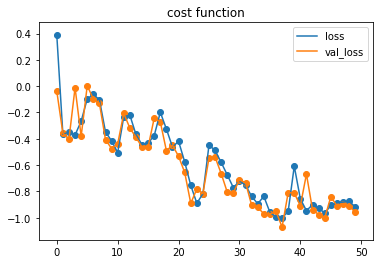

weight-encode:  (196, 64) bias-encode:  (64,)
weight-decode:  (64, 196) bias-decode:  (196,)
h2:  (60000, 64)


In [5]:
# 构建第二层 196 -> 64
encoding_dim = 64
input_img = Input(shape=(196,))

model2 = Sequential()
model2.add(Dense(encoding_dim,input_shape=h1.shape[1:],activation='relu'))
model2.add(Dense(196,activation='relu'))

model2.summary()

# 训练第二层
epoch = 50
batch_size = 256

#sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=1e-8)
model2.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
#model2.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

#if ('round1_weights.h5'):
#    model.load_weights('round1_weights.h5') 
    
result = model2.fit(h1,h1,batch_size,epoch,shuffle=True,validation_data=(h1, h1))
score = model2.evaluate(h1, h1, verbose=0) # 评估测试集loss损失和精度acc

print("第二轮训练后测试 score(val_loss): ", score[0])  # loss损失
print("第二轮训练后测试 accuracy: ", score[1]) # 精度acc
print("耗时: ",(time.time() - t0), "s")

# 输出损失函数
plotResult(result)

#print(len(model.weights))
# 输出权重
w2 = model2.layers[0].get_weights()
w2T = model2.layers[-1].get_weights()
print("weight-encode: ", w2[0].shape, "bias-encode: ", w2[1].shape)
print("weight-decode: ", w2T[0].shape, "bias-decode: ", w2T[1].shape)

# 保存权重
model2.save_weights('round2_weights.h5') 

# 输出x_hat
encoder = Model(inputs=input_img, 
                outputs=Dense(encoding_dim,activation='relu')(input_img))
encoder.layers[-1].set_weights(w2)

h2 = encoder.predict(h1)
print("h2: ", h2.shape)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_13 (Dense)             (None, 64)                2112      
Total params: 4,192.0
Trainable params: 4,192
Non-trainable params: 0.0
_________________________________________________________________
Train on 60000 samples, validate on 60000 samples
Epoch 1/50
60000/60000 [==============================] - 1s - loss: 0.9328 - acc: 0.8612 - val_loss: 0.4114 - val_acc: 0.8869
Epoch 2/50
60000/60000 [==============================] - 1s - loss: -0.2877 - acc: 0.8961 - val_loss: -1.0155 - val_acc: 0.9017
Epoch 3/50
60000/60000 [==============================] - 1s - loss: -1.3140 - acc: 0.9018 - val_loss: -1.4739 - val_acc: 0.9018
Epoch 4/50
60000/60000 [==============================] - 1s - loss: -1.5107 - acc: 0.9018 - val_

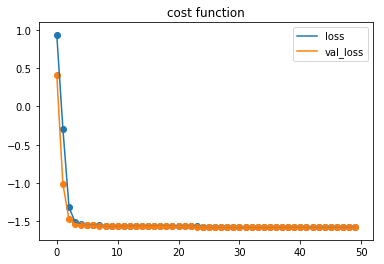

weight-encode:  (64, 32) bias-encode:  (32,)
weight-decode:  (32, 64) bias-decode:  (64,)
h3:  (60000, 32)


In [6]:
# 构建第三层 64 -> 32
encoding_dim = 32
input_img = Input(shape=(64,))

model3 = Sequential()
model3.add(Dense(encoding_dim,input_shape=h2.shape[1:],activation='relu'))
model3.add(Dense(64,activation='relu'))

model3.summary()

# 训练第三层
epoch = 50
batch_size = 256

#sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=1e-8)
#model3.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model3.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

#if ('round1_weights.h5'):
#    model.load_weights('round1_weights.h5') 
    
result = model3.fit(h2,h2,batch_size,epoch,shuffle=True,validation_data=(h2, h2))
score = model3.evaluate(h2, h2, verbose=0) # 评估测试集loss损失和精度acc

print("第三轮训练后测试 score(val_loss): ", score[0])  # loss损失
print("第三轮训练后测试 accuracy: ", score[1]) # 精度acc
print("耗时: ",(time.time() - t0), "s")

# 输出损失函数
plotResult(result)

#print(len(model.weights))
# 输出权重
w3 = model3.layers[0].get_weights()
w3T = model3.layers[-1].get_weights()
print("weight-encode: ", w3[0].shape, "bias-encode: ", w3[1].shape)
print("weight-decode: ", w3T[0].shape, "bias-decode: ", w3T[1].shape)

# 保存权重
model3.save_weights('round3_weights.h5') 

# 输出x_hat
encoder = Model(inputs=input_img, 
                outputs=Dense(encoding_dim,activation='relu')(input_img))
encoder.layers[-1].set_weights(w3)

h3 = encoder.predict(h2)
print("h3: ", h3.shape)

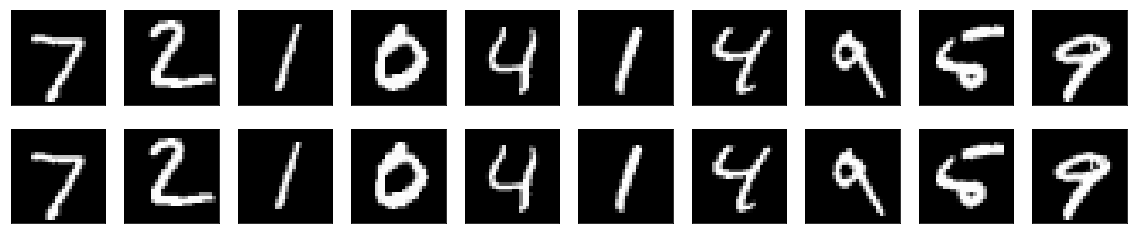

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 196)               153860    
_________________________________________________________________
dense_16 (Dense)             (None, 64)                12608     
_________________________________________________________________
dense_17 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_18 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_19 (Dense)             (None, 196)               12740     
_________________________________________________________________
dense_20 (Dense)             (None, 784)               154448    
_________________________________________________________________
dense_21 (Dense)             (None, 10)                7850      
Total para

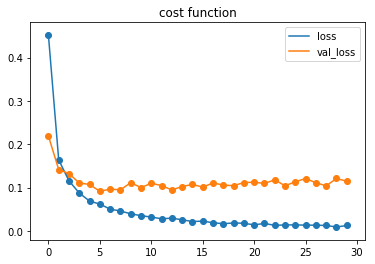

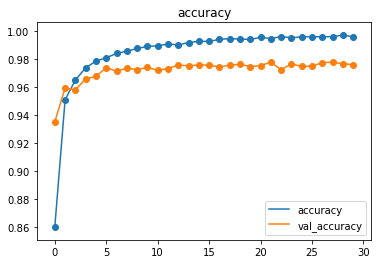

In [7]:
# Fine-tuning

model = Sequential()

model.add(Dense(196,input_shape=x_train.shape[1:],activation='relu'))
model.layers[-1].set_weights(w1) #784,196

model.add(Dense(64,activation='relu'))
model.layers[-1].set_weights(w2) #196,64

model.add(Dense(32,activation='relu'))
model.layers[-1].set_weights(w3) # 64, 32

model.add(Dense(64,activation='relu'))
model.layers[-1].set_weights(w3T) # 32,64

model.add(Dense(196,activation='relu'))
model.layers[-1].set_weights(w2T) # 64, 196

model.add(Dense(784,activation='relu')) # 196, 784
model.layers[-1].set_weights(w1T)

decoded = model.predict(x_test)

displayDigits(10,x_test,decoded)

model.add(Dense(10,activation='softmax'))

model.summary()

# 训练softmax层
epoch = 30
batch_size = 128

#sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=1e-8)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

result = model.fit(x_train,y_train,batch_size,epoch,shuffle=True,validation_data=(x_test,y_test))
score = model.evaluate(x_test, y_test, verbose=0) # 评估测试集loss损失和精度acc

print("Fine-Tuning训练后测试 score(val_loss): ", score[0])  # loss损失
print("Fine-Tuning训练后测试 accuracy: ", score[1]) # 精度acc
print("耗时: ",(time.time() - t0), "s")

model.save_weights('autoencoding_weights.h5') 

# 输出损失函数
plotResult(result)

plt.figure
plt.title("accuracy")
plt.plot(result.epoch,result.history['acc'],label="accuracy")
plt.plot(result.epoch,result.history['val_acc'],label="val_accuracy")
plt.scatter(result.epoch,result.history['acc'])
plt.scatter(result.epoch,result.history['val_acc'])
plt.legend(loc='lower right')
plt.show()
